<h1>引入套件</h1>

In [4]:
import os
import io
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

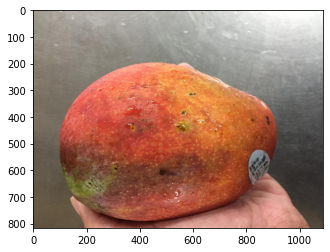

In [5]:
img_path = 'C:/Users/a2335/Documents/dataset/Test_Image/07686.jpg'

bgr_img = cv2.imread(img_path)

rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

gray_img = gray_img.astype("float32") / 255

plt.imshow(rgb_img, cmap = 'gray')
plt.show()



<h1>讀取標記csv檔</h1>

In [6]:
import pandas as pd

train_df = pd.read_csv('C:/Users/a2335/Documents/dataset/train.csv')
test_df = pd.read_csv('C:/Users/a2335/Documents/dataset/Test.csv')

train_df.head()

,image_id,label
0,00002.jpg,C
1,00003.jpg,C
2,00004.jpg,B
3,00005.jpg,A
4,00007.jpg,A


<h1>將路徑中的影像用opencv2依序讀取，並做完前處理之後，放到list中</h1>

In [7]:
train_img_path = 'C:/Users/a2335/Documents/dataset/Train_Image'
test_img_path = 'C:/Users/a2335/Documents/dataset/Test_Image'

train_images = []
test_images = []

for image_id in train_df['image_id'].values:
    image = cv2.imread(os.path.join(train_img_path, image_id))  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    train_images.append(image)

for image_id in test_df['image_id'].values:
    image = cv2.imread(os.path.join(test_img_path, image_id))  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    test_images.append(image)

train_images = np.array(train_images)
test_images = np.array(test_images)

In [8]:
train_images = np.array(train_images)
test_images = np.array(test_images)

<h1>將label進行前處理</h1>

In [9]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

train_labels = le.fit_transform(train_df['label'])
test_labels = le.fit_transform(test_df['label'])

In [10]:
train_labels = to_categorical(train_labels, 3)
test_labels = to_categorical(test_labels, 3)

<h1>建構神經網路</h1>

In [51]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))


model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation='softmax'))

In [55]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 64)       

<h1>將驗證準確率最高的權重存起來</h1>

In [60]:
filepath = "weights.best.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

<h1>將訓練集中的20%切成驗證集</h1>

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

<h1>計算recall、precision以及f1</h1>

In [45]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
     recall = true_positives / (possible_positives + K.epsilon())
     return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

<h1>訓練模型</h1>

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    #vertical_flip=True,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(train_images)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision_m, recall_m, f1_m])

history = model.fit_generator(datagen.flow(train_images,  train_labels), epochs=20, validation_data=(X_valid, y_valid), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/20
192/192 [==============================] - 27s 133ms/step - loss: 2.1754 - accuracy: 0.3405 - precision_m: 0.0562 - recall_m: 0.0435 - f1_m: 0.0468 - val_loss: 1.0942 - val_accuracy: 0.3491 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
192/192 [==============================] - 25s 128ms/step - loss: 1.0642 - accuracy: 0.4151 - precision_m: 0.2293 - recall_m: 0.0583 - f1_m: 0.0829 - val_loss: 0.9572 - val_accuracy: 0.4943 - val_precision_m: 0.5495 - val_recall_m: 0.2768 - val_f1_m: 0.3653
Epoch 3/20
192/192 [==============================] - 25s 130ms/step - loss: 0.9864 - accuracy: 0.4807 - precision_m: 0.5214 - recall_m: 0.2181 - f1_m: 0.2927 - val_loss: 0.9017 - val_accuracy: 0.5228 - val_precision_m: 0.6217 - val_recall_m: 0.3187 - val_f1_m: 0.4188
Epoch 4/20
192/192 [==============================] - 24s 126ms/step - loss: 0.9261 - accuracy: 0.5303 - precision_m: 0.5889 - recall_m: 0.3224 - f1_m: 0.4111 - val_loss: 0.8760 - v

<h1>用測試集評估模型</h1>

8/8 - 0s - loss: 0.5418 - accuracy: 0.7800 - precision_m: 0.7960 - recall_m: 0.7572 - f1_m: 0.7759


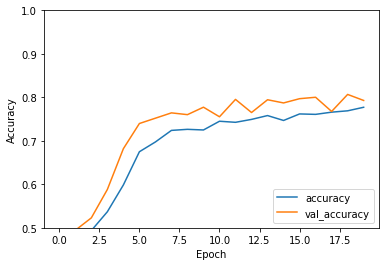

In [54]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

model.load_weights("weights.best.hdf5")

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)[:2]